In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
# import wqet_grader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In this project, you're working for a client who wants to create a model that can predict the price of apartments in the city of Buenos Aires — with a focus on apartments that cost less than $400,000 USD.WQU WorldQuant University Applied Data Science Lab QQQQ

## Prepare Data
### Import
In the previous project, we cleaned our data files one-by-one. This isn't an issue when you're working with just three files, but imagine if you had several hundred! One way to automate the data importing and cleaning process is by writing a function. This will make sure that all our data undergoes the same process, and that our analysis is easily reproducible — something that's very important in science in general and data science in particular.

<b> Task 2.1.1: Write a function named wrangle that takes a file path as an argument and returns a DataFrame.</b>

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    #subset to "capital federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    #subset to "Apartment"
    mask_apt = df["property_type"] == "apartment"
    #subset to proce_usd
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]
    #subset to area
    low , high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_area]
    return df

<b> Task 2.1.2: Use your wrangle function to create a DataFrame df from the CSV file data/buenos-aires-real-estate-1.csv.</b>

In [3]:
df = wrangle(r"C:\Users\MEER\Desktop\applied datascience course\project 2 house price prediction\buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1343, 17)


,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,30,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,41,sell,apartment,|Argentina|Capital Federal|Constituci�n|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,42,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


For this project, we want to build a model for apartments in Buenos Aires proper ("Capital Federal") that cost less than $400,000. Looking at the first five rows of our DataFrame, we can already see that there properties that fall outside those parameters. So our first cleaning task is to remove those observations from our dataset. Since we're using a function to import and clean our data, we'll need to make changes there.

<b> Task 2.1.3: Add to your wrangle function so that the DataFrame it returns only includes apartments in Buenos Aires ("Capital Federal") that cost less than $400,000 USD. Then recreate df from data/buenos-aires-real-estate-1.csv by re-running the cells above.</b>

In [4]:
mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
mask_apt = df["property_type"] == "apartment"
mask_price = df["price_aprox_usd"] < 400_000

#copy all inside wrangle function

In [5]:
# Check your work
assert (
    len(df) <= 1781
), f"`df` should have no more than 1781 observations, not {len(df)}."

### Explore
We saw in the previous project that property size is an important factor in determining price. With that in mind, let's look at the distribution of apartment sizes in our dataset.

<b> Task 2.1.4: Create a histogram of "surface_covered_in_m2". Make sure that the x-axis has the label "Area [sq meters]" and the plot has the title "Distribution of Apartment Sizes".</b>

Text(0.5, 1.0, 'Distribution of Apartment Sizes')

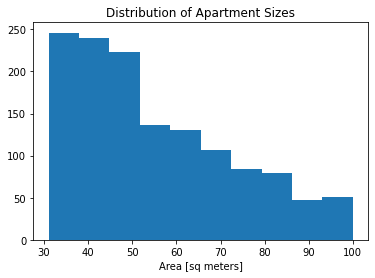

In [6]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes")

Yikes! When you see a histogram like the one above, it suggests that there are outliers in your dataset. This can affect model performance — especially in the sorts of linear models we'll learn about in this project. To confirm, let's look at the summary statistics for the "surface_covered_in_m2" feature.

<b> Task 2.1.5: Calculate the summary statistics for df using the describe method.</b>

In [7]:
df.describe()["surface_covered_in_m2"]

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

The statistics above confirm what we suspected. While most of the apartments in our dataset are smaller that 73 square meters, there are some that are several thousand square meters. The best thing to do is to change our wrangle function and remove them from the dataset.

In [8]:
low , high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low,high)


This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if thing we want to predict is price, size will be a good feature to include.

# intro to linear model
### Split
A key part in any model-building project is separating your target (the thing you want to predict) from your features (the information your model will use to make its predictions). Since this is our first model, we'll use just one feature: apartment size.

In [9]:
df.head()

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,30,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,41,sell,apartment,|Argentina|Capital Federal|Constituci�n|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,42,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


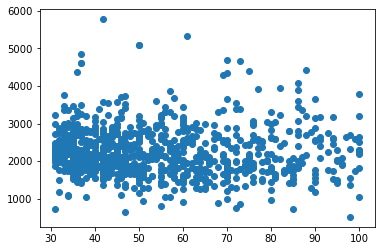

In [10]:
plt.scatter(df["surface_covered_in_m2"],df["price_usd_per_m2"])

<b> Task 2.1.8: Create the feature matrix named X_train, which you'll use to train your model. It should contain one feature only: ["surface_covered_in_m2"]. Remember that your feature matrix should always be two-dimensional.</b>

In [11]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

In [12]:
# Check your work
assert X_train.shape == (
    1343,
    1,
), f"The shape of `X_train` should be (1343, 1), not {X_train.shape}."

Now that we have a features, the next step is to create a target. (By the way, you may have noticed that we're adding a _train tag to the variable names for our feature matrix and target vector. This is to remind us that this is the data we'll use to train our model, and not the data we'll use to test it.)

<b> Task 2.1.9: Create the target vector named y_train, which you'll use to train your model. Your target should be "price_aprox_usd". Remember that, in most cases, your target vector should be one-dimensional.</b>

In [13]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape
# target should be a series not a dataframe

(1343,)

In [14]:
# Check your work
assert y_train.shape == (1343,)

# Build Model
### Baseline
The first step in building a model is baselining. To do this, ask yourself how you will know if the model you build is performing well?" One way to think about this is to see how a "dumb" model would perform on the same data. Some people also call this a naïve or baseline model, but it's always a model makes only one prediction — in this case, it predicts the same price regardless of an apartment's size. So let's start by figuring out what our baseline model's prediction should be.

<b> Task 2.1.10: Calculate the mean of your target vector y_train and assign it to the variable y_mean.</b>

In [15]:
y_mean = y_train.mean()
y_mean

135527.83871928512

Now that we have the one prediction that our dumb model will always make, we need to generate a list that repeats the prediction for every observation in our dataset.

<b> Task 2.1.11: Create a list named y_pred_baseline that contains the value of y_mean repeated so that it's the same length at y.</b>

In [16]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline
len(y_pred_baseline) == len(y_train)

True

So how does our baseline model perform? One way to evaluate it is by plotting it on top of the scatter plot we made above.

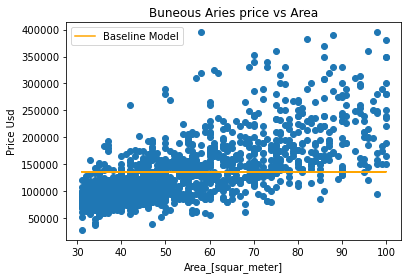

In [17]:
plt.plot(X_train.values,y_pred_baseline, color = "orange", label = "Baseline Model")
plt.scatter(X_train,y_train)
plt.xlabel("Area_[squar_meter]")
plt.ylabel("Price Usd")
plt.title("Buneous Aries price vs Area")
plt.legend();

Looking at this visualization, it seems like our baseline model doesn't really follow the trend in the data. But, as a data scientist, you can't depend only on a subjective plot to evaluate a model. You need an exact, mathematically calculate <b> <b> performance metric</b> . There are lots of performance metrics, but the one we'll use here is the <b>mean absolute error.</b>

<b> Task 2.1.13: Calculate the baseline mean absolute error for your predictions in y_pred_baseline as compared to the true targets in y.</b>

In [18]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


What does this information tell us? If we always predicted that an apartment price is $135,527.84 ,our predictions would be off by an average of $45,199.46. It also tells us that our model needs to have mean absolute error below $45,199.46 in order to be useful.

## Iterate
The next step in building a model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance. Even though the model we're building is linear, the iteration process rarely follows a straight line. Be prepared for trying new things, hitting dead-ends, and waiting around while your computer does long computations to train your model. ☕️ Let's get started!

The first thing we need to do is create our model — in this case, one that uses linear regression.

<b> Task 2.1.14: Instantiate a LinearRegression model named model. </b>

In [19]:
model = LinearRegression()

In [20]:
# Check your work
assert isinstance(model, LinearRegression)

The second thing we need to do is use our data to train our model. Another way to say this is fit our model to the training data.

<b> Task 2.1.15: Fit your model to the data, X_train and y_train.</b>

In [21]:
model.fit(X_train,y_train)

LinearRegression()

In [22]:
# Check your work
check_is_fitted(model)

## Evaluate
The final step is to evaluate our model. In order to do that, we'll start by seeing how well it performs when making predictions for data that it saw during training. So let's have it predict the price for the houses in our training set.

<b> Task 2.1.16: Using your model's predict method, create a list of predictions for the observations in your feature matrix X_train. Name this array y_pred_training.</b>

In [23]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [24]:
# Check your work
assert (
    len(y_pred_training) == 1343
), f"There should be 1343 predictions in `y_pred_training`, not {len(y_pred_training)}."

Now that we have predictions, we'll use them to assess our model's performance with the training data. We'll use the same metric we used to evaluate our baseline model: mean absolute error.

<b> Task 2.1.17: Calculate your training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.</b>

In [25]:
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


Good news: Our model beat the baseline by over $10,000! That's a good indicator that it will be helpful in predicting apartment prices. But the real test is how the model performs on data that it hasn't seen before, data that we call the test set. In the future, you'll create your own test set before you train your model,

# Warning: 
During the iteration phase, you can change and retrain your model as many times as you want. You can also check the model's training performance repeatedly. But once you evaluate its test performance, you can't make any more changes.

A test only counts if neither the model nor the data scientist has seen the data before. If you check your test metrics and then make changes to the model, you can introduce biases into the model that compromise its generalizability

# Communicate Results
Once your model is built and tested, it's time to share it with others. If you're presenting to simple linear model to a technical audience, they might appreciate an equation. When we created our baseline model, we represented it as a line. The equation for a line like this is usually written as:

### Equation: y = m*x + b
Since data scientists often work with more complicated linear models, they prefer to write the equation as:

### Equation: y = beta 0 + beta 1 * x
Regardless of how we write the equation, we need to find the values that our model has determined for the intercept and and coefficient. Fortunately, all trained models in scikit-learn store this information in the model itself. Let's start with the intercept.

<b> Task 2.1.19: Extract the intercept from your model, and assign it to the variable intercept.</b>

In [26]:
intercept = round(model.intercept_,2)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.31


Next comes the coefficient. We'll extract it in a very similar way.

<b> Task 2.1.20: Extract the coefficient associated "surface_covered_in_m2" in your model, and assign it to the variable coefficient.</b>

In [27]:
coefficient = round(model.coef_[0],2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.12


Now that we have our intercept and coefficient, we need to insert them into a string that we can print out the complete equation.

<b> Task 2.1.21: Complete the code below and run the cell to print the equation that your model has determined for predicting apartment price based on size.</b>

In [28]:
print(f"apt_price = {intercept} + {coefficient} * surface_covered")

apt_price = 11433.31 + 2253.12 * surface_covered


Equation might work for some technical audiences, but visualization or generally much more effective communication tool — especially for non-technical audiences. So let's use the scatter plot we made at the beginning of this lesson and plot the line that that are equation would make.

<b> Task 2.1.22: Add a line to the plot below that shows the relationship between the observations in X_train and your model's predictions y_pred_training. Be sure that the line color is red, and that it has the label "Linear Model".</b>

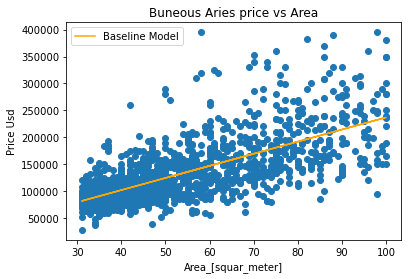

In [29]:
plt.plot(X_train,model.predict(X_train), color = "orange", label = "Baseline Model")
plt.scatter(X_train,y_train)
plt.xlabel("Area_[squar_meter]")
plt.ylabel("Price Usd")
plt.title("Buneous Aries price vs Area")
plt.legend();

In [31]:
df.to_csv("buenos-aires-real-estate-11.csv")

In [32]:
df.shape

(1343, 17)